<a href="https://colab.research.google.com/github/reflectormensah/Financial-Engineering-Data-Science/blob/main/Commodities_Forecast_and_Risk_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pandas-datareader
! pip install arch
! pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 16.7 MB/s eta 0:00:00


In [ ]:
# Importing the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import display, Math
from statsmodels.tsa.stattools import adfuller
import os
import glob
import requests
from datetime import datetime

%matplotlib inline

In [ ]:
!pip install fredapi
!pip install pandas requests


In [ ]:
!pip install scikeras

In [ ]:

from google.colab import files

# manually upload the file "Commodities"
uploaded = files.upload()


Saving Commodities.xlsx to Commodities.xlsx


In [ ]:
data = uploaded['Commodities.xlsx']

In [ ]:
# Read the excel file into a Pandas DataFrame
data = pd.read_excel('Commodities.xlsx')


In [ ]:
data.columns

Index(['Date', 'Cocoa', 'Gold', 'Crude Oil'], dtype='object')

#### Cleaning and Visualization

In [ ]:
data.head()

,Date,Cocoa,Gold,Crude Oil
0,2007-01-03,1684.0,642.5,60.55
1,2007-01-04,1684.0,629.8,58.32
2,2007-01-05,1659.0,625.0,55.78
3,2007-01-08,1607.0,610.3,56.85
4,2007-01-09,1589.0,613.5,55.64


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date',inplace=True)

In [ ]:
data.ffill(inplace=True)

In [ ]:
data.dropna(inplace=True)


data.head(5)

,Cocoa,Gold,Crude Oil
Date,,,
2007-01-03,1684.0,642.5,60.55
2007-01-04,1684.0,629.8,58.32
2007-01-05,1659.0,625.0,55.78
2007-01-08,1607.0,610.3,56.85
2007-01-09,1589.0,613.5,55.64


In [ ]:
#drop any 0 values in the data

data = data[(data != 0).all(axis=1)]


data.isna().any()

,0
Cocoa,False
Gold,False
Crude Oil,False


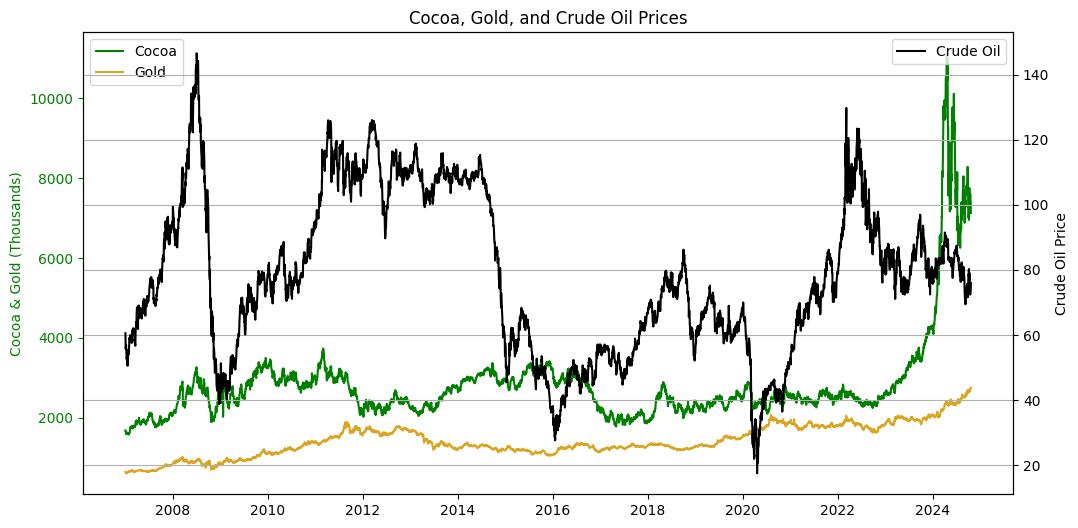

In [ ]:
# do data analytics by plotting the Cocoa, Gold and Crude Oil such that leftside y-axis will be in the thousands and the rightside y-axis be used for Crude Oil prices

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Cocoa and Gold on the left y-axis
ax1.plot(data.index, data['Cocoa'], label='Cocoa', color='green')
ax1.plot(data.index, data['Gold'], label='Gold', color='goldenrod')
ax1.set_ylabel('Cocoa & Gold (Thousands)', color='green')
ax1.tick_params('y', colors='green')
ax1.legend(loc='upper left')

# Create a second y-axis for Crude Oil
ax2 = ax1.twinx()
ax2.plot(data.index, data['Crude Oil'], label='Crude Oil', color='black')
ax2.set_ylabel('Crude Oil Price', color='black')
ax2.tick_params('y', colors='black')
ax2.legend(loc='upper right')


plt.title('Cocoa, Gold, and Crude Oil Prices')
plt.grid(True)
plt.show()

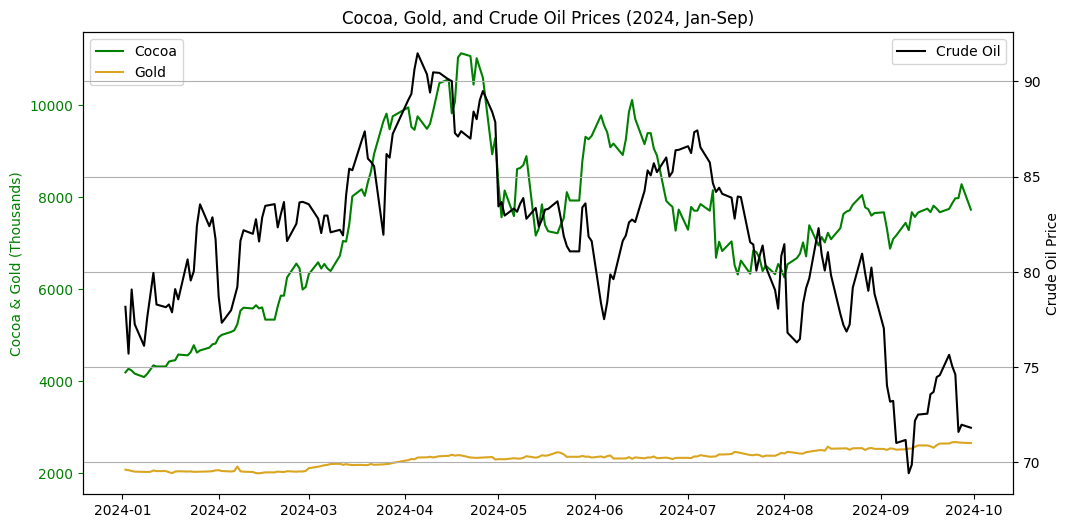

In [ ]:
#Only 2024 part of the data ( January to September  only)

# Filter the data for 2024 and January to September
data_2024 = data[(data.index.year == 2024) & (data.index.month >= 1) & (data.index.month <= 9)]

# Create the plot using the filtered data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Cocoa and Gold on the left y-axis
ax1.plot(data_2024.index, data_2024['Cocoa'], label='Cocoa', color='green')
ax1.plot(data_2024.index, data_2024['Gold'], label='Gold', color='goldenrod')
ax1.set_ylabel('Cocoa & Gold (Thousands)', color='green')
ax1.tick_params('y', colors='green')
ax1.legend(loc='upper left')

# Create a second y-axis for Crude Oil
ax2 = ax1.twinx()
ax2.plot(data_2024.index, data_2024['Crude Oil'], label='Crude Oil', color='black')
ax2.set_ylabel('Crude Oil Price', color='black')
ax2.tick_params('y', colors='black')
ax2.legend(loc='upper right')

plt.title('Cocoa, Gold, and Crude Oil Prices')
plt.grid(True)
plt.show()

## Gold Price Analysis and Forecasting



- Factors affecting the price of gold include interest rate, currency fluctuation, inflation, geopolitical events and market sentiments.
We resorted to modeling the gold price forecast with data from yahoo finance, FRED and other reliable sources for modeling and validation.


In [ ]:
# Dollar Index

dxy = yf.download('DX-Y.NYB', start='2007-01-02', end='2024-10-22')['Adj Close']


dxy.head()
print(dxy)


[*********************100%***********************]  1 of 1 completed

Ticker                       DX-Y.NYB
Date                                 
2007-01-02 00:00:00+00:00   83.199997
2007-01-03 00:00:00+00:00   83.919998
2007-01-04 00:00:00+00:00   84.320000
2007-01-05 00:00:00+00:00   84.629997
2007-01-08 00:00:00+00:00   84.599998
...                               ...
2024-10-15 00:00:00+00:00  103.260002
2024-10-16 00:00:00+00:00  103.589996
2024-10-17 00:00:00+00:00  103.830002
2024-10-18 00:00:00+00:00  103.489998
2024-10-21 00:00:00+00:00  104.010002

[4481 rows x 1 columns]


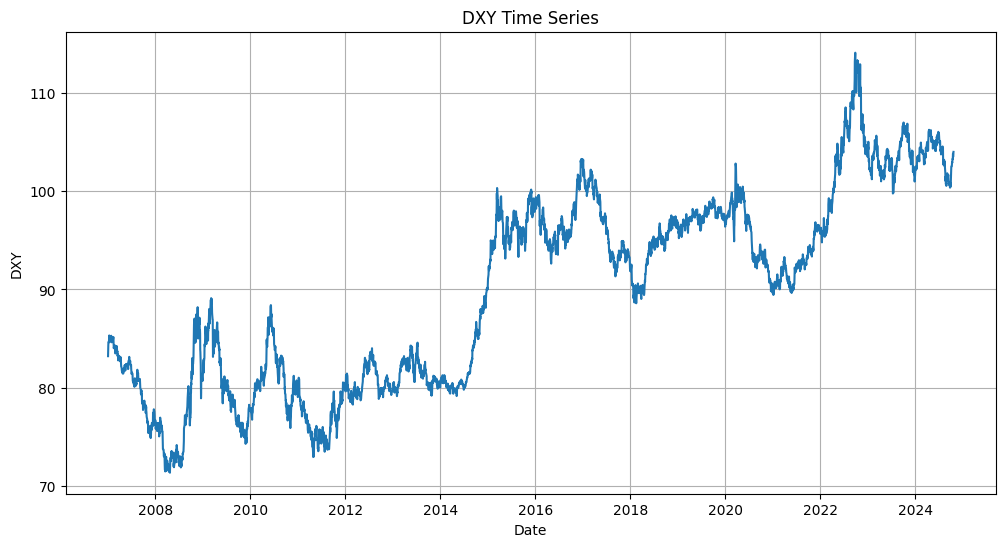

In [ ]:
#plot the dxy as a time series data

plt.figure(figsize=(12, 6))
plt.plot(dxy)
plt.title('DXY Time Series')
plt.xlabel('Date')
plt.ylabel('DXY')
plt.grid(True)
plt.show()

### Data on Interest Rate and Inflation from FRED Database

In [ ]:
from fredapi import Fred

fred = Fred(api_key='999c6af10214ea4a34459ebbd6e74c6f')
interest_rate = fred.get_series('DFF')
print(interest_rate)

interest_rate = interest_rate['2007-01-02':]  #data from Jan-02-2007 till date

# Convert the series to a DataFrame
interest_rate_df = pd.DataFrame(interest_rate, columns=['Interest Rate'])

#inflation_rate

inflation_rate = fred.get_series('CPIAUCSL')

inflation_rate = inflation_rate['2007-01-02':] # U.S. Consumer Price Index for All Urban Consumers
print(inflation_rate)


#geopolitical events
import pandas as pd
events = pd.read_csv('http://data.gdeltproject.org/events/index.html')


1954-07-01    1.13
1954-07-02    1.25
1954-07-03    1.25
1954-07-04    1.25
1954-07-05    0.88
              ... 
2024-10-26    4.83
2024-10-27    4.83
2024-10-28    4.83
2024-10-29    4.83
2024-10-30    4.83
Length: 25690, dtype: float64
2007-02-01    204.226
2007-03-01    205.288
2007-04-01    205.904
2007-05-01    206.755
2007-06-01    207.234
               ...   
2024-05-01    313.225
2024-06-01    313.049
2024-07-01    313.534
2024-08-01    314.121
2024-09-01    314.686
Length: 212, dtype: float64


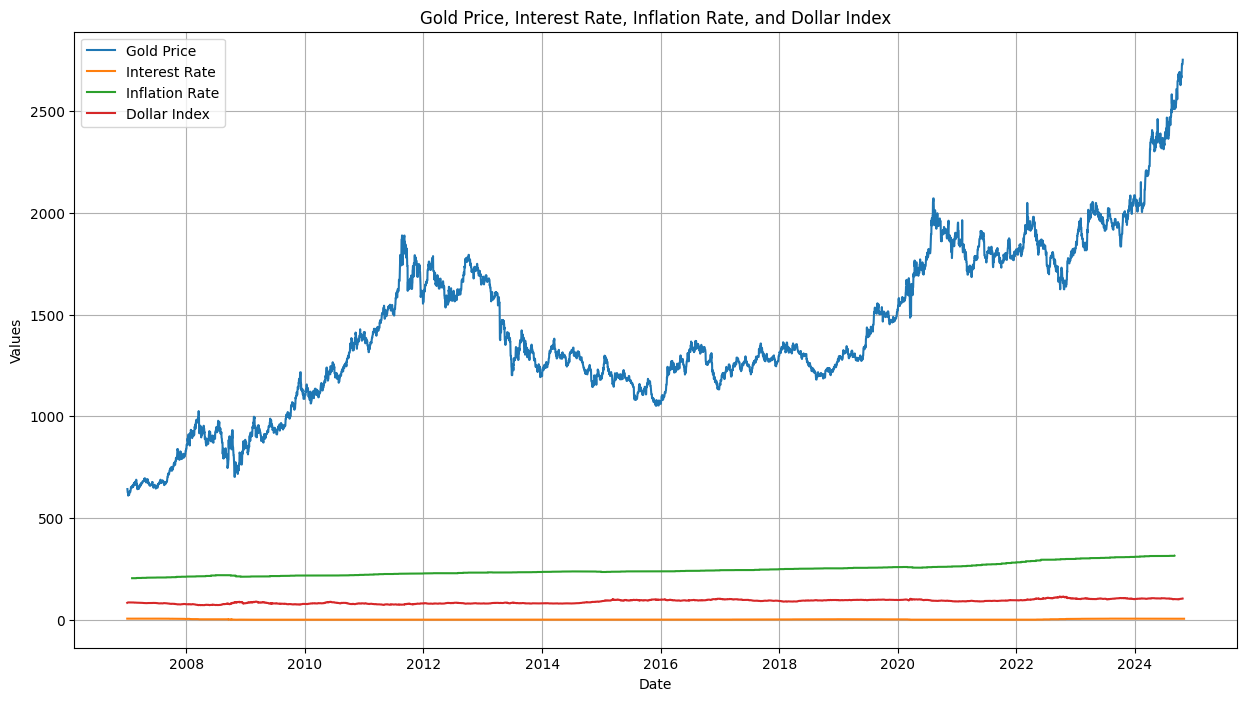

In [ ]:
#put the gold price, interest rate, inflation rate, dollar index and gold price in one dataframe and plot them on on one graph


import pandas as pd

# Resample the dataframes to daily frequency
gold_price_df = data['Gold'].resample('D').ffill()
interest_rate_df = interest_rate_df.resample('D').ffill()
inflation_rate_df = pd.DataFrame(inflation_rate).resample('D').ffill()
dxy_df = dxy.resample('D').ffill()

# Convert all datetime indices to timezone-naive
gold_price_df.index = gold_price_df.index.tz_localize(None)
interest_rate_df.index = interest_rate_df.index.tz_localize(None)
inflation_rate_df.index = inflation_rate_df.index.tz_localize(None)
dxy_df.index = dxy_df.index.tz_localize(None)

# Combine all dataframes into a single dataframe
combined_df = pd.concat([gold_price_df, interest_rate_df, inflation_rate_df, dxy_df], axis=1)
combined_df.columns = ['Gold Price', 'Interest Rate', 'Inflation Rate', 'Dollar Index']

# Now let's plot all the data on one graph

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
for column in combined_df.columns:
    plt.plot(combined_df.index, combined_df[column], label=column)

plt.title('Gold Price, Interest Rate, Inflation Rate, and Dollar Index')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

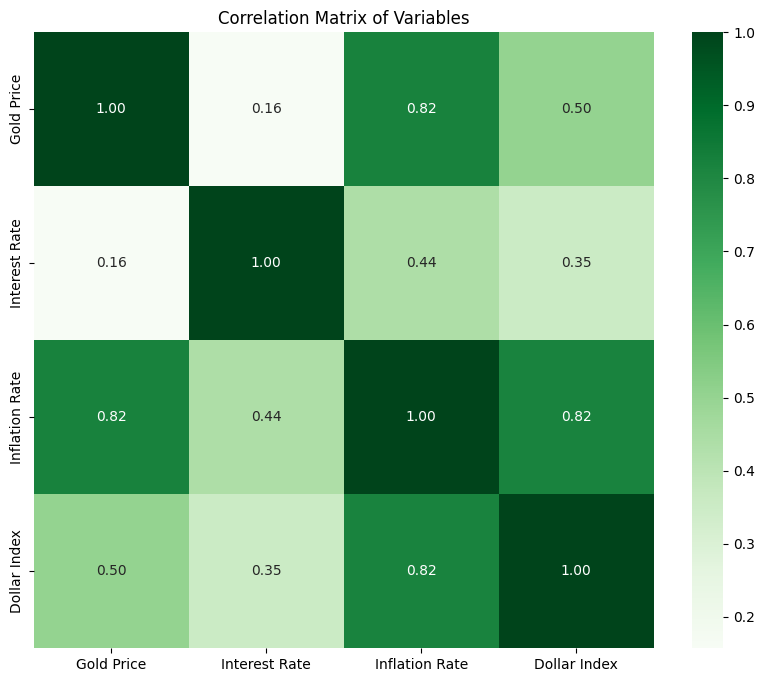

In [ ]:
#show the correlation among the variables in combined dataframe

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Create the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
# Change 'greens' to a valid colormap name like 'Greens'
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()


In [ ]:
# Calculate the percentage change for each variable
combined_df_pct_change = combined_df.pct_change(fill_method=None)

# Drop rows with missing values (NaNs) after calculating percentage change
combined_df_pct_change.dropna(inplace=True)

# Calculate the correlation between gold price change and other variables' changes
correlation_with_gold = combined_df_pct_change.corr()['Gold Price']

# Print the correlation in percentage terms
print("Percentage Impact on Gold Price:")
for variable, correlation in correlation_with_gold.items():
    if variable != 'Gold Price':
        print(f"{variable}: {correlation * 100:.2f}%")


Percentage Impact on Gold Price:
Interest Rate: 1.72%
Inflation Rate: 2.96%
Dollar Index: -15.25%


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1050
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064
Epoch 10/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064
Epoch 11/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063
Epoch 12/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 13/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 14/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 15/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

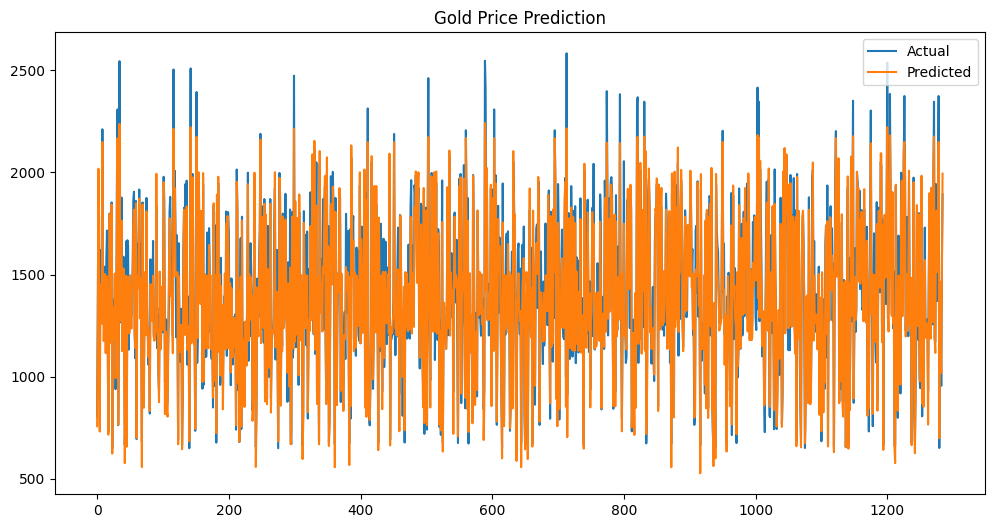

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Remove rows with missing values
combined_df.dropna(inplace=True)

# Prepare the data
X = combined_df[['Interest Rate', 'Inflation Rate', 'Dollar Index']].values
y = combined_df['Gold Price'].values.reshape(-1, 1)

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print('MSE:', loss)

# Make predictions and inverse-transform to get original scale
y_pred = scaler_y.inverse_transform(model.predict(X_test))
y_test_inv = scaler_y.inverse_transform(y_test)

# Plotting predicted vs actual gold prices
plt.figure(figsize=(12, 6))
plt.title('Gold Price Prediction')
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [ ]:
#using random forest, identify the non-linear relationship  between gold price with inflation, interest rate and dollar index

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare the data
X = combined_df[['Interest Rate', 'Inflation Rate', 'Dollar Index']]
y = combined_df['Gold Price']

# Drop rows with NaN values in either X or y
combined_df.dropna(inplace=True)  # Drop NaNs from combined_df

# Re-assign X and y after dropping NaNs
X = combined_df[['Interest Rate', 'Inflation Rate', 'Dollar Index']]
y = combined_df['Gold Price']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

# Analyze feature importance
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
print(feature_importance_df.sort_values('Importance', ascending=False))

RMSE: 20.283854766923003
          Feature  Importance
1  Inflation Rate    0.944263
0   Interest Rate    0.038823
2    Dollar Index    0.016914


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#use johansen test for checking the cointegration between gold price and inflation rate, dollar index

from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assuming your data is in the combined_df DataFrame

# Select the variables for the Johansen test
data_for_johansen = combined_df[['Gold Price', 'Inflation Rate', 'Dollar Index']]

# Perform the Johansen test
result = coint_johansen(data_for_johansen, det_order=0, k_ar_diff=1)

# Print the results
print(result.lr1)
print(result.cvt)
result.eig

# Interpret the results
# - lr1: Trace statistic
# - cvt: Critical values
# - eig: Eigenvalues

# If the trace statistic is greater than the critical value,
# then we reject the null hypothesis of no cointegration.

# You can also analyze the eigenvalues to see the strength of the cointegration relationship.

[36.20507137  9.01403371  3.64040643]
[[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


array([0.00422575, 0.00083653, 0.00056679])

From our data analysis, we realize relatively low positive correlation among Gold and Inflation & Interest Rates. However, there is a negative correlation between _gold price_ and _Dollar Index_.

Using ML's Random Forest to check the long-term non-linear relationship; factoring how inflation, interest rate and Dollar Index affects the prices of gold, we realized over that past **17 years**:
- Inflation rate of 94.43% affects the price of gold.
- Interest rate of 3.88% affects the price of gold.

- Dollar Index has about 1.69%, showing minimal effect (but higher in negative correlation from past analysis.

NB: Using cointegration, and the eigenvalues and eigenvectors such Random Forests' results.

Epoch 1/100
1064/1064 - 16s - 15ms/step - loss: 0.0033
Epoch 2/100
1064/1064 - 21s - 20ms/step - loss: 0.0011
Epoch 3/100
1064/1064 - 13s - 13ms/step - loss: 9.1878e-04
Epoch 4/100
1064/1064 - 21s - 20ms/step - loss: 6.2390e-04
Epoch 5/100
1064/1064 - 19s - 18ms/step - loss: 6.4993e-04
Epoch 6/100
1064/1064 - 13s - 13ms/step - loss: 5.5691e-04
Epoch 7/100
1064/1064 - 20s - 19ms/step - loss: 4.9948e-04
Epoch 8/100
1064/1064 - 21s - 20ms/step - loss: 5.0342e-04
Epoch 9/100
1064/1064 - 20s - 19ms/step - loss: 4.8944e-04
Epoch 10/100
1064/1064 - 21s - 20ms/step - loss: 4.5287e-04
Epoch 11/100
1064/1064 - 20s - 19ms/step - loss: 4.7133e-04
Epoch 12/100
1064/1064 - 20s - 19ms/step - loss: 4.4148e-04
Epoch 13/100
1064/1064 - 20s - 19ms/step - loss: 4.2936e-04
Epoch 14/100
1064/1064 - 13s - 12ms/step - loss: 4.4743e-04
Epoch 15/100
1064/1064 - 20s - 19ms/step - loss: 4.2697e-04
Epoch 16/100
1064/1064 - 22s - 21ms/step - loss: 4.5015e-04
Epoch 17/100
1064/1064 - 19s - 18ms/step - loss: 4.2208e-

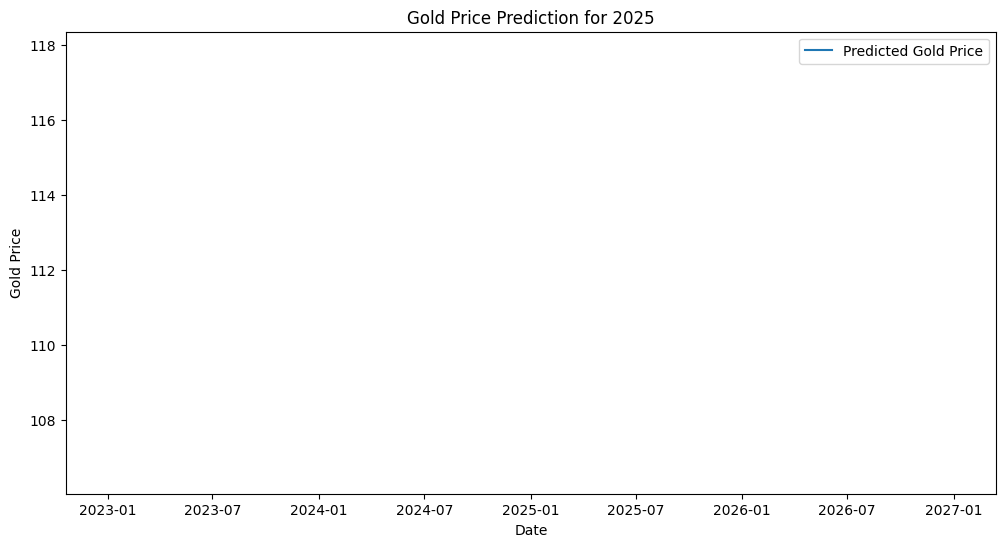

In [ ]:
# prompt: using the LSTM neural network, predict the full year of 2025 for gold price, using the historicals of interest rates, inflation, dollar index and gold prices

# Prepare data for LSTM prediction
# We will use the last 3 years of data for training
train_data = combined_df[-1095:]  # 3 years of daily data (approx)

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Create sequences for LSTM input
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30 # Number of days to look back
X_train, y_train = create_dataset(train_data_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

from keras.layers import Input

# Build the LSTM model with an Input layer to specify input shape
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Predict for 2025
# Create a dataset for the prediction period (2025)
# You might need to manually create a DataFrame with hypothetical values
# for Interest Rate, Inflation Rate, and Dollar Index for 2025.
# Here, we assume constant values for these features.

future_dates = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')
future_df = pd.DataFrame(index=future_dates)
future_df['Interest Rate'] = combined_df['Interest Rate'].iloc[-1]
future_df['Inflation Rate'] = combined_df['Inflation Rate'].iloc[-1]
future_df['Dollar Index'] = combined_df['Dollar Index'].iloc[-1]

# Combine the last look_back days of the training data and future data for prediction
last_look_back_days = train_data[-look_back:]
prediction_input = pd.concat([last_look_back_days, future_df])

# Scale the input
prediction_input_scaled = scaler.transform(prediction_input)

# Create sequences for LSTM prediction
X_predict, _ = create_dataset(prediction_input_scaled, look_back)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions_scaled.shape[0], 3)), predictions_scaled), axis=1))[:, 3]

# Adjust the future_dates to match the length of predictions
future_dates = future_dates[:len(predictions)]  # This line is added

# Create a DataFrame for the predictions
prediction_df = pd.DataFrame({'Date': future_dates, 'Gold Price': predictions})
prediction_df.set_index('Date', inplace=True)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(prediction_df['Gold Price'], label='Predicted Gold Price')
plt.title('Gold Price Prediction for 2025')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()


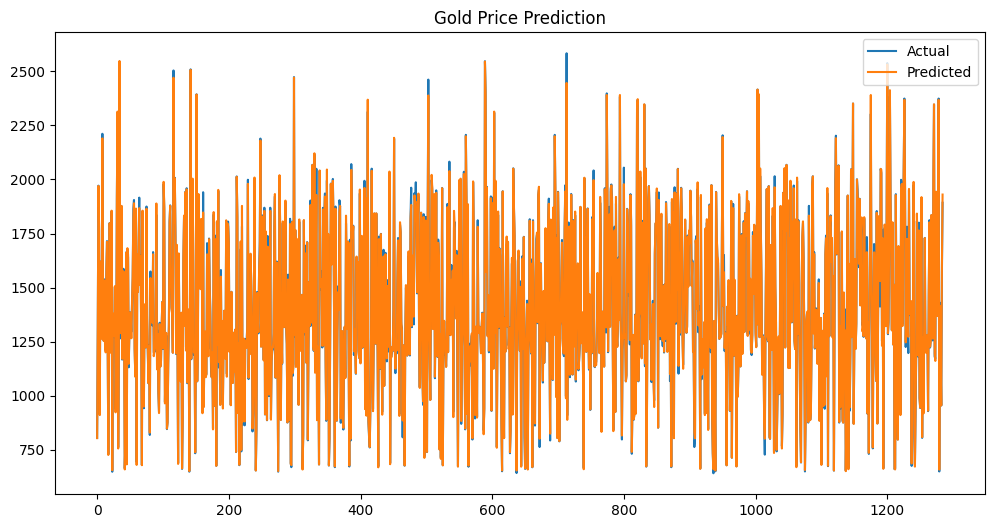

In [ ]:
# Plotting predicted vs actual gold prices
plt.figure(figsize=(12, 6))
plt.title('Gold Price Prediction')
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


# Plot the predictions for 2025
#plt.figure(figsize=(12, 6))
#plt.plot(prediction_df.index, prediction_df['Gold Price'], label='Predicted Gold Price for 2025')
#plt.title('Gold Price Prediction for 2025')
#plt.xlabel('Date')
#plt.ylabel('Gold Price')
#plt.legend()
#plt.show()

# You can add more visualizations like:
# - Residual plots (difference between actual and predicted)
# - Histogram of errors
# - Box plots of errors
# - Scatter plots comparing actual and predicted values for specific features
# - Time series plots for actual and predicted values together

             Gold Price Classification
Date                                  
2025-01-01   804.570000            Low
2025-01-02  1321.676000            Low
2025-01-03  1970.113000           High
2025-01-04  1767.827400         Medium
2025-01-05   911.052667            Low


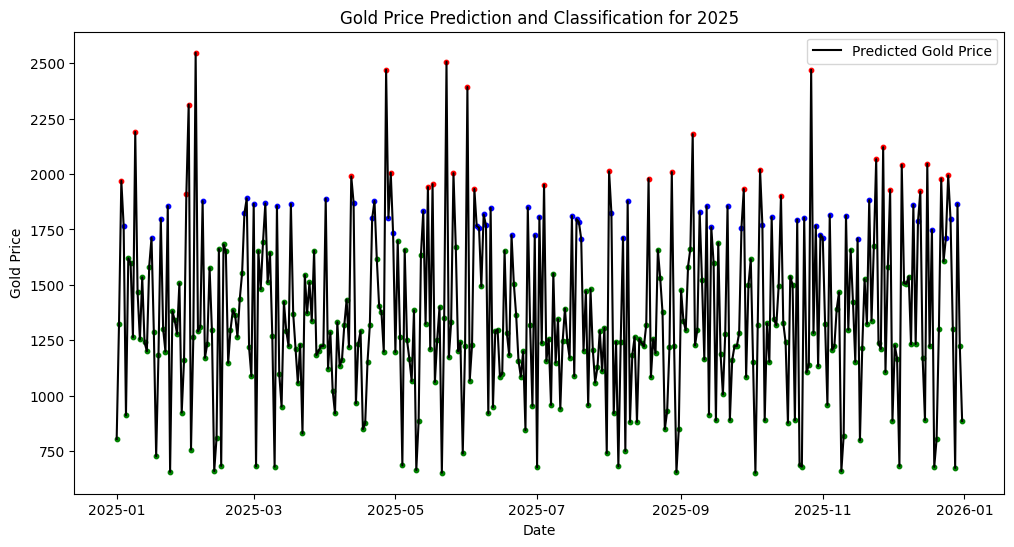

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_pred holds your LSTM model predictions for 2025
# Generate dates for the full year of 2025
dates_2025 = pd.date_range(start="2025-01-01", end="2025-12-31", freq='D')
predicted_prices = np.array(y_pred[:len(dates_2025)])  # Trim or extend to match date range

# Create DataFrame with dates and predictions
prediction_df = pd.DataFrame(data={'Date': dates_2025, 'Gold Price': predicted_prices})
prediction_df.set_index('Date', inplace=True)

# Classify the predicted gold prices
def classify_gold_price(price):
    if price > 1900:
        return "High"
    elif price < 1700:
        return "Low"
    else:
        return "Medium"

# Apply classification
prediction_df['Classification'] = prediction_df['Gold Price'].apply(classify_gold_price)

# Check results
print(prediction_df.head())

# Visualization of classifications
plt.figure(figsize=(12, 6))
plt.plot(prediction_df.index, prediction_df['Gold Price'], label='Predicted Gold Price', color='black')
for date, row in prediction_df.iterrows():
    color = 'red' if row['Classification'] == 'High' else 'green' if row['Classification'] == 'Low' else 'blue'
    plt.scatter(date, row['Gold Price'], color=color, s=10)
plt.title('Gold Price Prediction and Classification for 2025')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()


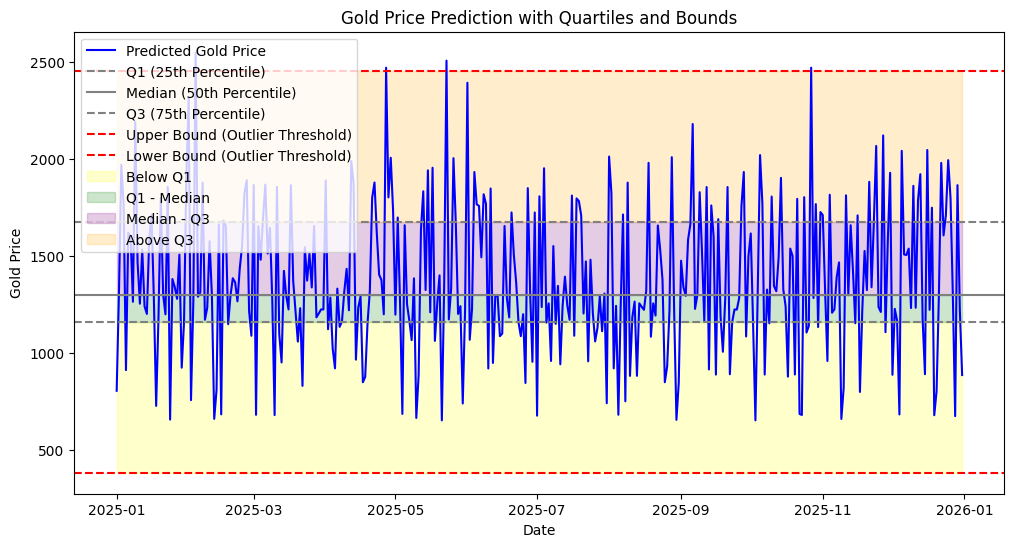

In [ ]:
# Calculate quartiles for the predicted gold prices
q1 = prediction_df['Gold Price'].quantile(0.25)
q2 = prediction_df['Gold Price'].quantile(0.50)
q3 = prediction_df['Gold Price'].quantile(0.75)

# Calculate the interquartile range (IQR)
iqr = q3 - q1

# Calculate upper and lower bounds for outliers
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the predicted gold prices
ax.plot(prediction_df.index, prediction_df['Gold Price'], label='Predicted Gold Price', color='blue')

# Add horizontal lines for quartiles
ax.axhline(y=q1, color='gray', linestyle='--', label='Q1 (25th Percentile)')
ax.axhline(y=q2, color='gray', linestyle='-', label='Median (50th Percentile)')
ax.axhline(y=q3, color='gray', linestyle='--', label='Q3 (75th Percentile)')

# Add horizontal lines for upper and lower bounds
ax.axhline(y=upper_bound, color='red', linestyle='--', label='Upper Bound (Outlier Threshold)')
ax.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound (Outlier Threshold)')

# Shade areas for each quartile
ax.fill_between(prediction_df.index, lower_bound, q1, color='yellow', alpha=0.2, label='Below Q1')
ax.fill_between(prediction_df.index, q1, q2, color='green', alpha=0.2, label='Q1 - Median')
ax.fill_between(prediction_df.index, q2, q3, color='purple', alpha=0.2, label='Median - Q3')
ax.fill_between(prediction_df.index, q3, upper_bound, color='orange', alpha=0.2, label='Above Q3')

# Set labels and legend
ax.set_title('Gold Price Prediction with Quartiles and Bounds')
ax.set_xlabel('Date')
ax.set_ylabel('Gold Price')
ax.legend(loc='upper left')

# Display the plot
plt.show()


In [ ]:
# Assuming prediction_df is your DataFrame with 'Gold Price' and 'Date'
# as columns, and the index is 'Date'.

# Calculate the quarters of 2025
q1_start = '2025-01-01'
q1_end = '2025-03-31'
q2_start = '2025-04-01'
q2_end = '2025-06-30'
q3_start = '2025-07-01'
q3_end = '2025-09-30'
q4_start = '2025-10-01'
q4_end = '2025-12-31'

# Get the predicted prices for each quarter
q1_prices = prediction_df[q1_start:q1_end]['Gold Price']
q2_prices = prediction_df[q2_start:q2_end]['Gold Price']
q3_prices = prediction_df[q3_start:q3_end]['Gold Price']
q4_prices = prediction_df[q4_start:q4_end]['Gold Price']

# Print the values for each quarter with lower and upper bounds
print("Q1 2025:")
print("Lower Bound:", q1_prices.min())
print("Upper Bound:", q1_prices.max())
print("Values:", q1_prices.values)

print("\nQ2 2025:")
print("Lower Bound:", q2_prices.min())
print("Upper Bound:", q2_prices.max())
print("Values:", q2_prices.values)

print("\nQ3 2025:")
print("Lower Bound:", q3_prices.min())
print("Upper Bound:", q3_prices.max())
print("Values:", q3_prices.values)

print("\nQ4 2025:")
print("Lower Bound:", q4_prices.min())
print("Upper Bound:", q4_prices.max())
print("Values:", q4_prices.values)

Q1 2025:
Lower Bound: 656.0960000000005
Upper Bound: 2547.682999999997
Values: [ 804.57       1321.676      1970.113      1767.8274      911.05266667
 1619.981      1599.112      1263.547      2190.239      1466.516
 1253.6        1533.46723333 1240.66       1200.93104762 1582.67433492
 1712.222      1286.041       726.68746667 1182.34       1798.0944
 1300.5184746  1198.968      1855.795       656.096      1380.831
 1340.216      1278.61118182 1506.791       923.72432143 1158.637
 1909.95233333 2313.805       756.442      1263.547      2547.683
 1289.58       1311.88716389 1878.118      1170.783      1233.397
 1575.929      1295.792       659.836       809.464      1661.77111548
  683.121      1682.43533333 1652.017      1148.08       1295.562
 1384.97225    1364.007      1266.048      1436.7885     1552.475
 1822.946      1890.25       1217.423      1088.353      1865.584
  680.59335    1652.61       1480.362      1692.912      1867.627
 1512.184      1644.309      1270.328       679

In [ ]:
# Create a new DataFrame for the quarters of 2025
quarters_2025_df = pd.DataFrame(index=['Q1 2025', 'Q2 2025', 'Q3 2025', 'Q4 2025'])

# Iterate through the quarters and calculate the statistics
for quarter in ['Q1 2025', 'Q2 2025', 'Q3 2025', 'Q4 2025']:
    # Define start and end dates for each quarter using correct month ends
    if quarter == "Q1 2025":
        start_date = pd.to_datetime('2025-01-01')
        end_date = pd.to_datetime('2025-03-31')
    elif quarter == "Q2 2025":
        start_date = pd.to_datetime('2025-04-01')
        end_date = pd.to_datetime('2025-06-30') # Corrected end date for Q2
    elif quarter == "Q3 2025":
        start_date = pd.to_datetime('2025-07-01')
        end_date = pd.to_datetime('2025-09-30')
    elif quarter == "Q4 2025":
        start_date = pd.to_datetime('2025-10-01')
        end_date = pd.to_datetime('2025-12-31')

    quarter_data = prediction_df.loc[start_date:end_date]
    if not quarter_data.empty:
        quarters_2025_df.loc[quarter, 'Lower Bound'] = quarter_data['Gold Price'].min()
        quarters_2025_df.loc[quarter, 'Upper Bound'] = quarter_data['Gold Price'].max()
        quarters_2025_df.loc[quarter, 'Median'] = quarter_data['Gold Price'].median()
    else:
        quarters_2025_df.loc[quarter, 'Lower Bound'] = np.nan
        quarters_2025_df.loc[quarter, 'Upper Bound'] = np.nan
        quarters_2025_df.loc[quarter, 'Median'] = np.nan

# Display the DataFrame
quarters_2025_df

,Lower Bound,Upper Bound,Median
Q1 2025,656.096000,2547.683,1316.781582
Q2 2025,652.106833,2506.818,1297.751000
Q3 2025,654.763000,2180.172,1250.828633
Q4 2025,652.106833,2470.530,1326.973154


### Feature Engineering

ML Engineering to convert the geopolitical news over the years into numerical dataframe for analysis.


In [ ]:
#geopolitical events
import pandas as pd

# First you need to find the specific GDELT event data file link
# from the index HTML. Replace with your desired file url.
gdelt_event_file_url = 'http://data.gdeltproject.org/events/20231027.export.CSV.zip' # Example GDELT Event file, please replace with the specific file URL you need

# Load the GDELT event data. This might take time depending on file size.
events = pd.read_csv(gdelt_event_file_url, compression='zip', sep='\t', header=None)
#geopolitical events
import pandas as pd

# First you need to find the specific GDELT event data file link
# from the index HTML. Replace with your desired file url.
gdelt_event_file_url = 'http://data.gdeltproject.org/events/20231027.export.CSV.zip' # Example GDELT Event file, please replace with the specific file URL you need

# Load the GDELT event data. This might take time depending on file size.
events = pd.read_csv(gdelt_event_file_url, compression='zip', sep='\t', header=None)

#Rename columns
column_names = ['GlobalEventID', 'Day', 'MonthYear', 'Year', 'FractionDate', 'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode', 'Actor1']
events.columns = column_names


ValueError: Length mismatch: Expected axis has 58 elements, new values have 10 elements

### Crude Oil Forecasting

#### 1. Historical Analysis

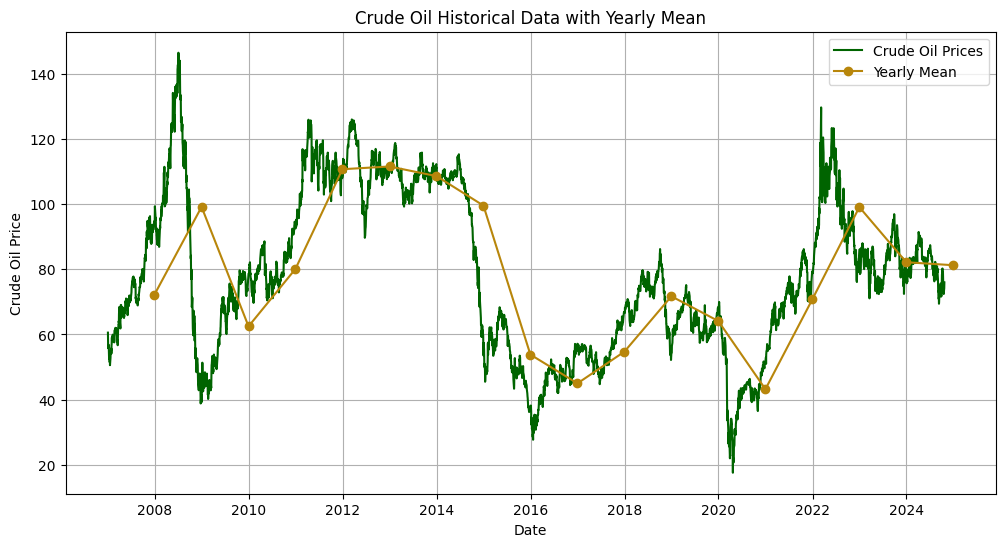

In [ ]:
#the historical data for crude oil and display the mean for each year on the plot. data from data['CrudeOil]

import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'CrudeOil' is the column with crude oil prices
# and it has a 'Date' index.

# the general means for all the years
gen_mean = data['Crude Oil'].mean()
# Group data by year and calculate the mean
yearly_means = data['Crude Oil'].resample('YE').mean()

# Plot the historical data
plt.figure(figsize=(12, 6))
plt.plot(data['Crude Oil'], color = 'darkgreen', label='Crude Oil Prices')
plt.plot(yearly_means, marker='o', linestyle='-', color='darkgoldenrod', label='Yearly Mean')
plt.xlabel('Date')
plt.ylabel('Crude Oil Price')
plt.title('Crude Oil Historical Data with Yearly Mean')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

import numpy as np
from arch import arch_model
import itertools

# Define the p, o, and q parameters to test
p = o = q = range(1, 10)
pq_combinations = list(itertools.product(p, o, q))

# Initialize variables to store the best models and their AIC and BIC
best_aic = float('inf')
best_bic = float('inf')
best_model_aic = None
best_model_bic = None
best_params_aic = None
best_params_bic = None

# Loop through all possible combinations of p, o, and q
for param in pq_combinations:
    try:
        # Fit the GARCH model
        model = arch_model(data['Crude Oil'], vol='GARCH', p=param[0], o=param[1], q=param[2])
        model_fit = model.fit(disp='off')

        # Check for the lowest AIC
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_model_aic = model_fit
            best_params_aic = param

        # Check for the lowest BIC
        if model_fit.bic < best_bic:
            best_bic = model_fit.bic
            best_model_bic = model_fit
            best_params_bic = param

        print(f"GARCH{param} - AIC: {model_fit.aic:.2f}, BIC: {model_fit.bic:.2f}")

    except Exception as e:
        print(f"GARCH{param} - Failed to fit. Error: {e}")

# Print the best models based on AIC and BIC
if best_params_aic is not None and best_params_bic is not None:
    print(f"\nBest GARCH model based on AIC: GARCH{best_params_aic} with AIC: {best_aic:.2f}")
    print(f"Best GARCH model based on BIC: GARCH{best_params_bic} with BIC: {best_bic:.2f}")
else:
    print("\nNo GARCH model could be successfully fit.")


GARCH(1, 1, 1) - AIC: 36248.08, BIC: 36280.07
GARCH(1, 1, 2) - AIC: 36249.69, BIC: 36288.09
GARCH(1, 1, 3) - AIC: 36250.09, BIC: 36294.89
GARCH(1, 1, 4) - AIC: 36245.57, BIC: 36296.76
GARCH(1, 1, 5) - AIC: 36247.57, BIC: 36305.16
GARCH(1, 1, 6) - AIC: 36249.36, BIC: 36313.36
GARCH(1, 1, 7) - AIC: 36249.96, BIC: 36320.35
GARCH(1, 1, 8) - AIC: 36250.06, BIC: 36326.86
GARCH(1, 1, 9) - AIC: 36252.06, BIC: 36335.26
GARCH(1, 2, 1) - AIC: 36250.08, BIC: 36288.47
GARCH(1, 2, 2) - AIC: 36251.69, BIC: 36296.49
GARCH(1, 2, 3) - AIC: 36252.09, BIC: 36303.29
GARCH(1, 2, 4) - AIC: 36247.57, BIC: 36305.16
GARCH(1, 2, 5) - AIC: 36249.57, BIC: 36313.56
GARCH(1, 2, 6) - AIC: 36251.36, BIC: 36321.75
GARCH(1, 2, 7) - AIC: 36251.96, BIC: 36328.75
GARCH(1, 2, 8) - AIC: 36252.06, BIC: 36335.26
GARCH(1, 2, 9) - AIC: 36254.06, BIC: 36343.65
GARCH(1, 3, 1) - AIC: 36252.08, BIC: 36296.87
GARCH(1, 3, 2) - AIC: 36253.69, BIC: 36304.89
GARCH(1, 3, 3) - AIC: 36254.09, BIC: 36311.68
GARCH(1, 3, 4) - AIC: 36249.57, BI

In [ ]:
# Split the data for training and testing
train_size = int(len(data['Crude Oil']) * 0.80)
train_data = data['Crude Oil'][:train_size]
test_data = data['Crude Oil'][train_size:]

# Assuming you want to use the best model based on AIC
# Replace with best_model_bic if you prefer BIC
garch_model_fit = best_model_aic

# Get in-sample fitted values
predictions = garch_model_fit.conditional_volatility

# Slice predictions to match test data
predictions = predictions[train_size:]

In [ ]:
# Forecast the next steps using simulation
forecast = garch_model_fit.forecast(horizon=len(test_data), method='simulation')

# Extract the forecasted values (mean) for the next periods
forecast_values = forecast.mean.iloc[-1].values

In [ ]:
# Calculate RMSE for the test data and forecast
rmse_test = np.sqrt(np.mean((test_data.values - predictions.values)**2))
print(f"RMSE for test data: {rmse_test}")

# Compare forecast with the last values of test data
rmse_forecast = np.sqrt(np.mean((test_data.values - forecast_values)**2))
print(f"RMSE for the forecast: {rmse_forecast}")


RMSE for test data: 73.34519681826114
RMSE for the forecast: 15.74495725813525


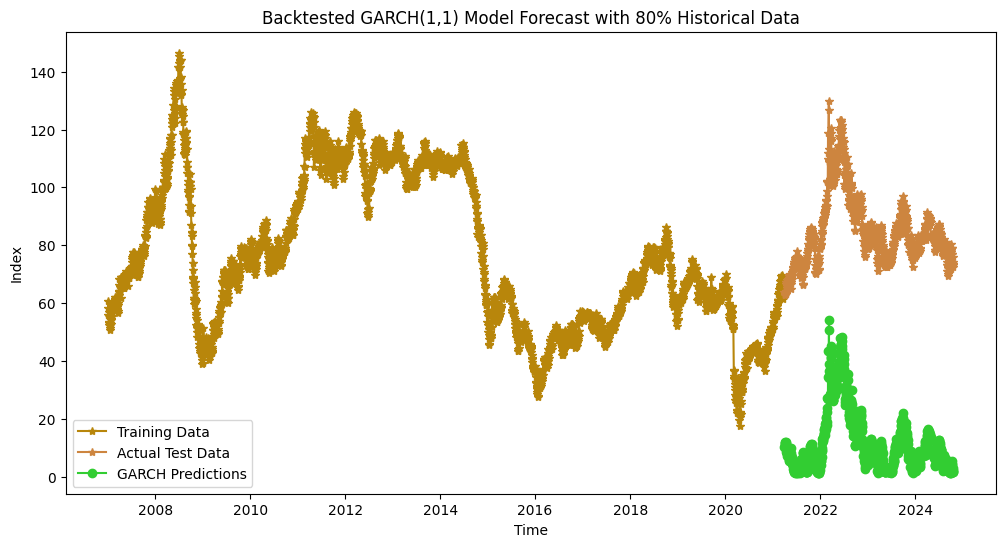

In [ ]:
# Plot the actual values, predictions, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='darkgoldenrod', marker='*')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='peru', marker='*')
plt.plot(test_data.index, predictions, label='GARCH Predictions', color='limegreen', marker='o')
plt.xlabel('Time')
plt.ylabel('Index')
plt.title('Backtested GARCH(1,1) Model Forecast with 80% Historical Data')
plt.legend()
plt.show()

In [ ]:
# Define the forecast horizon, for example, for 4 quarters in 2025
forecast_horizon = 4

forecasts = garch_model_fit.forecast(horizon=forecast_horizon, method='simulation')

# Extract the upper bounds of the forecast for 2025
upper_bounds_2025 = forecasts.mean.iloc[-1].values + np.sqrt(forecasts.variance.iloc[-1].values)


# Print the upper bounds for each quarter in 2025
print("GARCH Forecast for 2025 (Quarterly):")
for i, ub in enumerate(upper_bounds_2025):
    print(f"Q{i+1} 2025: {ub}")

# You can also plot these upper bounds if needed:
# plt.plot(forecast_horizon, upper_bounds_2025, label='Forecast Upper Bounds')

GARCH Forecast for 2025 (Quarterly):
Q1 2025: 76.61122308436116
Q2 2025: 77.11475379386006
Q3 2025: 77.35873795357588
Q4 2025: 77.74624672385664


### Cocoa Analysis and Forecasting

In [ ]:
# Convert 'na' values to NaN
data['Cocoa'] = pd.to_numeric(data['Cocoa'], errors='coerce')


data.dropna(subset=['Cocoa'], inplace=True)

# Plot time series data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Cocoa'], color ='darkgoldenrod')
plt.xlabel('Date')
plt.ylabel('Price in US$')
plt.title('Daily Time Series Analysis of Cocoa')
plt.grid(True)
plt.show()


KeyError: 'Date'

<Figure size 1200x600 with 0 Axes>

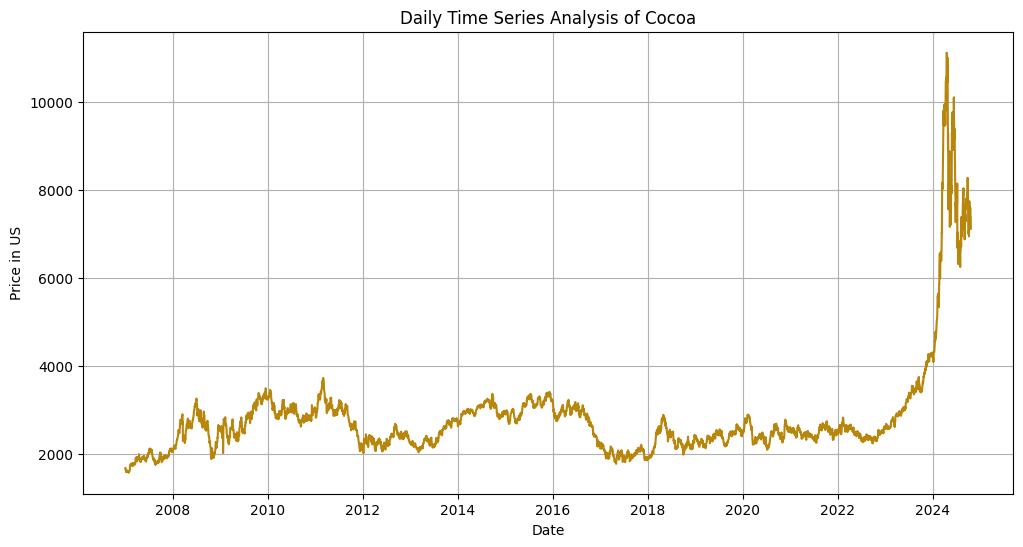

In [ ]:
# Convert 'na' values to NaN
data['Cocoa'] = pd.to_numeric(data['Cocoa'], errors='coerce')

# Remove rows with missing values in the 'Cocoa' column
data.dropna(subset=['Cocoa'], inplace=True)

# Plot time series data
plt.figure(figsize=(12, 6))
# If 'Date' is the index:
plt.plot(data.index, data['Cocoa'], color='darkgoldenrod')
# OR, If 'Date' is a column with a different name, e.g., 'Trade Date':
# plt.plot(data['Trade Date'], data['Cocoa'], color='darkgoldenrod')
plt.xlabel('Date')
plt.ylabel('Price in US')
plt.title('Daily Time Series Analysis of Cocoa')
plt.grid(True)
plt.show()

In [ ]:
!pip install --upgrade statsmodels

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import pandas as pd

# Ensure your data has a DateTime index with a frequency
data['Cocoa'].index = pd.DatetimeIndex(data['Cocoa'].index)
data['Cocoa'] = data['Cocoa'].asfreq('D')  # Adjust frequency as needed

# Define a smaller range for SARIMA parameters
p = d = q = range(0, 6)
pdq = list(itertools.product(p, d, q))

# Initialize variables to store the best models and their AIC and BIC
best_aic = float('inf')
best_bic = float('inf')
best_model_aic = None
best_model_bic = None
best_pdq_aic = None
best_pdq_bic = None

# Iterate through all combinations of p, d, q parameters
for param in pdq:
    try:
        # Fit SARIMA model
        model = SARIMAX(data['Cocoa'], order=param, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

        # Check AIC and BIC
        if model.aic < best_aic:
            best_aic = model.aic
            best_model_aic = model
            best_pdq_aic = param

        if model.bic < best_bic:
            best_bic = model.bic
            best_model_bic = model
            best_pdq_bic = param

        print(f"SARIMA{param} - AIC:{model.aic:.2f}, BIC:{model.bic:.2f}")

    except Exception as e:
        print(f"SARIMA{param} - Failed to fit. Error: {e}")

# Display the best models based on AIC and BIC
if best_pdq_aic is not None and best_pdq_bic is not None:
    print(f"\nBest SARIMA model based on AIC: SARIMA{best_pdq_aic} with AIC: {best_aic:.2f}")
    print(f"Best SARIMA model based on BIC: SARIMA{best_pdq_bic} with BIC: {best_bic:.2f}")
else:
    print("\nNo SARIMA model could be successfully fit.")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 0) - AIC:83912.36, BIC:83918.76
SARIMA(0, 0, 1) - AIC:80607.97, BIC:80620.77


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 2) - AIC:73034.57, BIC:73053.76


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(0, 0, 3) - AIC:68944.45, BIC:68970.05


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 0, 4) - AIC:67180.78, BIC:67212.77


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 5) - AIC:64326.56, BIC:64364.95
SARIMA(0, 1, 0) - AIC:52677.20, BIC:52683.60


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1) - AIC:52629.08, BIC:52641.88


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 2) - AIC:52614.38, BIC:52633.57


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 3) - AIC:52602.99, BIC:52628.59


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 4) - AIC:52584.40, BIC:52616.39


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 5) - AIC:52555.20, BIC:52593.59
SARIMA(0, 2, 0) - AIC:56149.88, BIC:56156.28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 2, 1) - AIC:52663.78, BIC:52676.57


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 2, 2) - AIC:52615.77, BIC:52634.96


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 2, 3) - AIC:52601.22, BIC:52626.81


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 2, 4) - AIC:52589.52, BIC:52621.51


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 2, 5) - AIC:52570.95, BIC:52609.34
SARIMA(0, 3, 0) - AIC:61185.77, BIC:61192.17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 3, 1) - AIC:56244.92, BIC:56257.72


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 3, 2) - AIC:53736.99, BIC:53756.19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 3, 3) - AIC:53396.69, BIC:53422.28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 3, 4) - AIC:53195.36, BIC:53227.35


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 3, 5) - AIC:53202.12, BIC:53240.51
SARIMA(0, 4, 0) - AIC:66605.06, BIC:66611.46


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 4, 1) - AIC:61418.37, BIC:61431.17


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 4, 2) - AIC:56335.96, BIC:56355.15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 4, 3) - AIC:55443.46, BIC:55469.05


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(0, 4, 4) - AIC:54878.21, BIC:54910.20


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 4, 5) - AIC:54772.24, BIC:54810.62
SARIMA(0, 5, 0) - AIC:72204.34, BIC:72210.74


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 5, 1) - AIC:67125.03, BIC:67137.83


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 5, 2) - AIC:61158.43, BIC:61177.62


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 5, 3) - AIC:59828.25, BIC:59853.84


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 5, 4) - AIC:58594.62, BIC:58626.61


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 5, 5) - AIC:57944.00, BIC:57982.38


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 0) - AIC:52689.97, BIC:52702.76


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 1) - AIC:52641.78, BIC:52660.97


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 2) - AIC:52627.37, BIC:52652.96


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 3) - AIC:52615.72, BIC:52647.71


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 4) - AIC:52597.18, BIC:52635.57


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 0, 5) - AIC:52568.16, BIC:52612.94
SARIMA(1, 1, 0) - AIC:52637.67, BIC:52650.46


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1) - AIC:52627.14, BIC:52646.33


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 2) - AIC:52610.55, BIC:52636.15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 3) - AIC:52585.51, BIC:52617.50


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 4) - AIC:52575.71, BIC:52614.10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 5) - AIC:52505.38, BIC:52550.16
SARIMA(1, 2, 0) - AIC:54490.11, BIC:54502.91


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 2, 1) - AIC:52624.00, BIC:52643.20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 2, 2) - AIC:52613.65, BIC:52639.24


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 2, 3) - AIC:52598.10, BIC:52630.09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(1, 2, 4) - AIC:52584.96, BIC:52623.35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 2, 5) - AIC:52561.66, BIC:52606.45
SARIMA(1, 3, 0) - AIC:58196.78, BIC:58209.58


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 3, 1) - AIC:54747.57, BIC:54766.76


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 3, 2) - AIC:53280.81, BIC:53306.41


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 3, 3) - AIC:53160.54, BIC:53192.52


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 3, 4) - AIC:53061.82, BIC:53100.21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 3, 5) - AIC:52929.55, BIC:52974.33


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 4, 0) - AIC:62592.00, BIC:62604.79


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 4, 1) - AIC:58430.69, BIC:58449.89


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(1, 4, 2) - AIC:54495.43, BIC:54521.02


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 4, 3) - AIC:54834.64, BIC:54866.63
SARIMA(1, 4, 4) - AIC:53965.47, BIC:54003.85


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 4, 5) - AIC:53982.42, BIC:54027.20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 5, 0) - AIC:67382.16, BIC:67394.96


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 5, 1) - AIC:62806.44, BIC:62825.63


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(1, 5, 2) - AIC:58176.19, BIC:58201.78
SARIMA(1, 5, 3) - AIC:58333.10, BIC:58365.08


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 5, 4) - AIC:56027.40, BIC:56065.79


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 5, 5) - AIC:56073.76, BIC:56118.54


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 0, 0) - AIC:52639.38, BIC:52658.58


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 0, 1) - AIC:52640.44, BIC:52666.03


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 0, 2) - AIC:52624.45, BIC:52656.45


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 0, 3) - AIC:52619.05, BIC:52657.44


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 0, 4) - AIC:52588.77, BIC:52633.56


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 0, 5) - AIC:52518.67, BIC:52569.86
SARIMA(2, 1, 0) - AIC:52626.35, BIC:52645.54


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 1, 1) - AIC:52623.82, BIC:52649.41


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 1, 2) - AIC:52623.26, BIC:52655.25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 1, 3) - AIC:52585.02, BIC:52623.41


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 1, 4) - AIC:52575.92, BIC:52620.70


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 1, 5) - AIC:52490.48, BIC:52541.67
SARIMA(2, 2, 0) - AIC:53868.09, BIC:53887.28


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 2, 1) - AIC:52623.65, BIC:52649.25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 2, 2) - AIC:52601.69, BIC:52633.68


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 2, 3) - AIC:52482.74, BIC:52521.12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 2, 4) - AIC:52486.32, BIC:52531.11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 2, 5) - AIC:52474.54, BIC:52525.72


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 3, 0) - AIC:56764.53, BIC:56783.73


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 3, 1) - AIC:53867.31, BIC:53892.90


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(2, 3, 2) - AIC:53067.30, BIC:53099.29
SARIMA(2, 3, 3) - AIC:53016.97, BIC:53055.35


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 3, 4) - AIC:52919.82, BIC:52964.61


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 3, 5) - AIC:52821.81, BIC:52872.99


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 4, 0) - AIC:60363.89, BIC:60383.08


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 4, 1) - AIC:56763.16, BIC:56788.76


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 4, 2) - AIC:54786.88, BIC:54818.87


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(2, 4, 3) - AIC:54269.24, BIC:54307.62


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 4, 4) - AIC:54171.52, BIC:54216.30


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 4, 5) - AIC:53464.28, BIC:53515.45


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 5, 0) - AIC:64359.13, BIC:64378.32


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 5, 1) - AIC:60361.02, BIC:60386.61


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(2, 5, 2) - AIC:56756.24, BIC:56788.22


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 5, 3) - AIC:56670.22, BIC:56708.60


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 5, 4) - AIC:55815.31, BIC:55860.09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 5, 5) - AIC:55369.60, BIC:55420.78


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 0, 0) - AIC:52628.12, BIC:52653.71


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 0, 1) - AIC:52625.56, BIC:52657.56


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 0, 2) - AIC:52658.50, BIC:52696.89


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 0, 3) - AIC:52613.44, BIC:52658.23


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(3, 0, 4) - AIC:52592.61, BIC:52643.79


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 0, 5) - AIC:52504.11, BIC:52561.70
SARIMA(3, 1, 0) - AIC:52614.76, BIC:52640.35


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 1, 1) - AIC:52612.86, BIC:52644.85


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(3, 1, 2) - AIC:52594.69, BIC:52633.09
SARIMA(3, 1, 3) - AIC:52557.11, BIC:52601.90


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(3, 1, 4) - AIC:52540.07, BIC:52591.26


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 1, 5) - AIC:52451.97, BIC:52509.55
SARIMA(3, 2, 0) - AIC:53537.87, BIC:53563.47


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 2, 1) - AIC:52613.07, BIC:52645.06


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 2, 2) - AIC:52586.95, BIC:52625.34


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 2, 3) - AIC:52507.68, BIC:52552.47


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 2, 4) - AIC:52494.77, BIC:52545.95


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 2, 5) - AIC:52475.57, BIC:52533.15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 3, 0) - AIC:56035.29, BIC:56060.88


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 3, 1) - AIC:53536.92, BIC:53568.91


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(3, 3, 2) - AIC:53231.89, BIC:53270.27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 3, 3) - AIC:52990.29, BIC:53035.08
SARIMA(3, 3, 4) - AIC:52950.58, BIC:53001.76


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 3, 5) - AIC:52811.26, BIC:52868.84


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 4, 0) - AIC:59348.97, BIC:59374.56


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 4, 1) - AIC:56034.23, BIC:56066.22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 4, 2) - AIC:54508.49, BIC:54546.87


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 4, 3) - AIC:54599.87, BIC:54644.65


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 4, 4) - AIC:54108.72, BIC:54159.90


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 4, 5) - AIC:53471.52, BIC:53529.09


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 5, 0) - AIC:63050.28, BIC:63075.87


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 5, 1) - AIC:59346.51, BIC:59378.49


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(3, 5, 2) - AIC:57186.21, BIC:57224.60


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 5, 3) - AIC:56289.14, BIC:56333.92


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(3, 5, 4) - AIC:55917.48, BIC:55968.66


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(3, 5, 5) - AIC:54838.14, BIC:54895.71


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 0, 0) - AIC:52616.57, BIC:52648.56


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 0, 1) - AIC:52618.42, BIC:52656.81


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 0, 2) - AIC:65745.94, BIC:65790.73


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 0, 3) - AIC:52570.43, BIC:52621.61


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(4, 0, 4) - AIC:52584.76, BIC:52642.34
SARIMA(4, 0, 5) - AIC:52509.50, BIC:52573.48
SARIMA(4, 1, 0) - AIC:52603.49, BIC:52635.48


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 1, 1) - AIC:52600.82, BIC:52639.21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 1, 2) - AIC:52554.54, BIC:52599.33


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 1, 3) - AIC:52548.91, BIC:52600.10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 1, 4) - AIC:52414.71, BIC:52472.29


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 1, 5) - AIC:52408.57, BIC:52472.54
SARIMA(4, 2, 0) - AIC:53189.89, BIC:53221.88


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 2, 1) - AIC:52601.64, BIC:52640.03


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(4, 2, 2) - AIC:52573.91, BIC:52618.70
SARIMA(4, 2, 3) - AIC:52574.35, BIC:52625.53


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 2, 4) - AIC:52487.09, BIC:52544.67


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 2, 5) - AIC:52392.01, BIC:52455.99


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 3, 0) - AIC:54975.18, BIC:55007.16


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 3, 1) - AIC:53188.81, BIC:53227.20


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(4, 3, 2) - AIC:52940.99, BIC:52985.78


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 3, 3) - AIC:53016.73, BIC:53067.91


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 3, 4) - AIC:52762.57, BIC:52820.14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 3, 5) - AIC:52685.33, BIC:52749.30


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 4, 0) - AIC:57815.66, BIC:57847.64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 4, 1) - AIC:54974.21, BIC:55012.59


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(4, 4, 2) - AIC:54166.00, BIC:54210.79


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 4, 3) - AIC:53920.89, BIC:53972.07


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 4, 4) - AIC:53679.72, BIC:53737.30


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 4, 5) - AIC:53284.73, BIC:53348.70


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 5, 0) - AIC:61260.39, BIC:61292.38


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(4, 5, 1) - AIC:57835.72, BIC:57874.11


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 5, 2) - AIC:56495.85, BIC:56540.63


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 5, 3) - AIC:55247.50, BIC:55298.68


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(4, 5, 4) - AIC:54804.57, BIC:54862.14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(4, 5, 5) - AIC:54829.50, BIC:54893.47


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 0, 0) - AIC:52605.35, BIC:52643.74


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 0, 1) - AIC:52578.78, BIC:52623.57


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 0, 2) - AIC:52622.44, BIC:52673.63


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(5, 0, 3) - AIC:52611.17, BIC:52668.75


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 0, 4) - AIC:52477.69, BIC:52541.67
SARIMA(5, 0, 5) - AIC:52424.10, BIC:52494.47
SARIMA(5, 1, 0) - AIC:52550.16, BIC:52588.55


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 1, 1) - AIC:52505.13, BIC:52549.92


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 1, 2) - AIC:52500.43, BIC:52551.62


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 1, 3) - AIC:52500.50, BIC:52558.08


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(5, 1, 4) - AIC:52417.87, BIC:52481.85


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 1, 5) - AIC:52408.29, BIC:52478.67
SARIMA(5, 2, 0) - AIC:53176.71, BIC:53215.10


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 2, 1) - AIC:52548.32, BIC:52593.11


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 2, 2) - AIC:52502.49, BIC:52553.67


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 2, 3) - AIC:52581.47, BIC:52639.05


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 2, 4) - AIC:52507.43, BIC:52571.41


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 2, 5) - AIC:52412.43, BIC:52482.81


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 3, 0) - AIC:54701.53, BIC:54739.91


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(5, 3, 1) - AIC:53175.39, BIC:53220.17
SARIMA(5, 3, 2) - AIC:52874.97, BIC:52926.15


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 3, 3) - AIC:53280.86, BIC:53338.44


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 3, 4) - AIC:53286.63, BIC:53350.61


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 3, 5) - AIC:52892.05, BIC:52962.42


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 4, 0) - AIC:57095.24, BIC:57133.62


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 4, 1) - AIC:54700.28, BIC:54745.06


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 4, 2) - AIC:54273.48, BIC:54324.66


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 4, 3) - AIC:53857.01, BIC:53914.59


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 4, 4) - AIC:53685.53, BIC:53749.51


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 4, 5) - AIC:53383.66, BIC:53454.03


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 5, 0) - AIC:60154.95, BIC:60193.33


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

SARIMA(5, 5, 1) - AIC:57289.80, BIC:57334.58


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 5, 2) - AIC:56406.02, BIC:56457.19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 5, 3) - AIC:55699.26, BIC:55756.83


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(5, 5, 4) - AIC:55046.72, BIC:55110.69


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(5, 5, 5) - AIC:54750.14, BIC:54820.51

Best SARIMA model based on AIC: SARIMA(4, 2, 5) with AIC: 52392.01
Best SARIMA model based on BIC: SARIMA(4, 2, 5) with BIC: 52455.99


In [ ]:
# SARIMA(4,2,5)
model = SARIMAX(data['Cocoa'], order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Cocoa   No. Observations:                 4444
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -26333.143
Date:                Fri, 01 Nov 2024   AIC                          52672.286
Time:                        21:23:52   BIC                          52691.484
Sample:                             0   HQIC                         52679.055
                               - 4444                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   6020.595      0.000       0.999       1.000
ma.L1         -0.0908      0.004    -21.352      0.000      -0.099      -0.082
sigma2      8195.9527     27.640    296.528      0.0

In [ ]:
import pandas as pd

# Generate forecasts for 2025
forecast = model_fit.get_forecast(steps=365)  # Forecast for the whole year

# Extract the predicted mean values and confidence intervals
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a date range for 2025 and set it as the index for forecast DataFrame
dates_2025 = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')
forecast_df = pd.DataFrame({'Forecast': forecast_mean.values,
                            'Lower Bound': confidence_intervals.iloc[:, 0].values,
                            'Upper Bound': confidence_intervals.iloc[:, 1].values},
                           index=dates_2025)

# Define the quarterly date ranges
q1 = ('2025-01-01', '2025-03-31')
q2 = ('2025-04-01', '2025-06-30')
q3 = ('2025-07-01', '2025-09-30')
q4 = ('2025-10-01', '2025-12-31')

# Print results for each quarter
print("Cocoa Forecast for 2025 (Quarterly):")

for quarter_start, quarter_end in [q1, q2, q3, q4]:
    quarter_forecast = forecast_df.loc[quarter_start:quarter_end]
    print(f"\n{quarter_start} - {quarter_end}:")
    print("Lower Bound:", quarter_forecast['Lower Bound'].min())
    print("Upper Bound:", quarter_forecast['Upper Bound'].max())
    print("Mean Forecast:", quarter_forecast['Forecast'].mean())


Cocoa Forecast for 2025 (Quarterly):

2025-01-01 - 2025-03-31:
Lower Bound: 5512.549395024391
Upper Bound: 8552.78161544412
Mean Forecast: 7089.075921500138

2025-04-01 - 2025-06-30:
Lower Bound: 4781.747104387368
Upper Bound: 9055.965895267795
Mean Forecast: 6974.980962166076

2025-07-01 - 2025-09-30:
Lower Bound: 4202.808054862827
Upper Bound: 9408.529876292392
Mean Forecast: 6861.492020466976

2025-10-01 - 2025-12-31:
Lower Bound: 3709.221206347037
Upper Bound: 9679.444990207387
Mean Forecast: 6749.24292799167


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


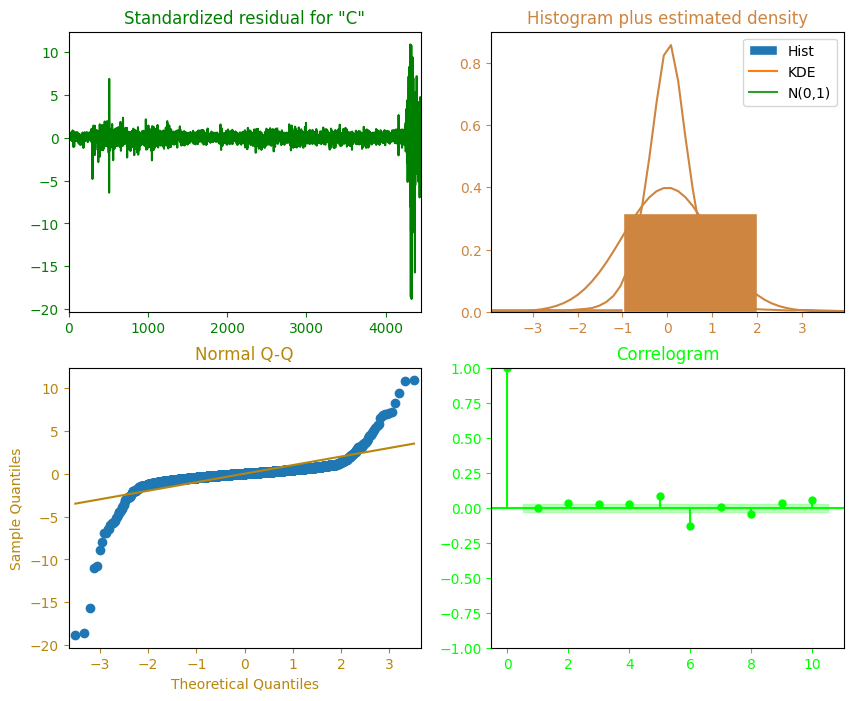

In [ ]:
# Residual diagnostics
fig = model_fit.plot_diagnostics(figsize=(10, 8))

# Access the subplots and set the colors manually
axes = fig.get_axes()

# Set specific colors for each subplot
colors = ['green', 'peru', 'darkgoldenrod', 'lime', 'black']

for ax, color in zip(axes, colors):
    # Set color for lines
    for line in ax.get_lines():
        line.set_color(color)

    for patch in ax.patches:
        patch.set_facecolor(color)

    # Change color of the scatter points (if any)
    if ax.collections:
        for collection in ax.collections:
            collection.set_color(color)

    # Set color for text and labels
    ax.title.set_color(color)
    ax.xaxis.label.set_color(color)
    ax.yaxis.label.set_color(color)
    ax.tick_params(axis='x', colors=color)
    ax.tick_params(axis='y', colors=color)

# Show the plot
plt.show()
